Tecnológico de Monterrey

Maestría en Inteligencia Artificial Aplicada

Profesor: Luis Eduardo Falcón Morales

Alumno: Juan Manuel Carballo

Matrícula: A01166758

In [1]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# base libraries to import
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Análsis de Desgaste en Empresas

En un mundo globalizado donde el personal calificado esta disponible no solo localmente, las empresas enfrentan un serio problema de atracción y retención de empleados si a esto se suma personal con burnout las empresas pueden enfrentar un serio problema de desgaste.

El Desgaste o Attrition es la tasa en la cual los empleados dejan su trabajo sin ser reemplazados ya sea si el empleado renuncio, fue retirado de su rol o despedido mientras su puesto actual no sea ocupado. [1]

La rotación de personal y el desgaste o attrition son problemáticas distintas mientras que en la primera las empresas vuelven a cubrir la vacante en la segunda la vacante queda vacía.

### Objetivo

En este notebook se predecira que empleados que son más propensos a terminar su relación laboral para esto se ocupara el dataset en [2] creado por IBM para estudiar este fenómeno.

## PARTE 1: Análisis descriptivo y preprocesamiento de los datos

In [4]:
# load the dataset
attrition_df = pd.read_csv('../datasets/HR-Employee-Attrition.csv')

In [5]:
# categorical columns
initial_categorical = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']

In [6]:
# convert initial categorical columns
for cat in initial_categorical:
    attrition_df[cat] = attrition_df[cat].astype('object')

**¿Cuántas y cuáles de las variables son numéricas?**

In [7]:
# get dtypes for columns
dtypes_df = attrition_df.dtypes.to_frame(name='dtype')
dtypes_df

,dtype
Age,int64
Attrition,object
BusinessTravel,object
DailyRate,int64
Department,object
DistanceFromHome,int64
Education,object
EducationField,object
EmployeeCount,int64
EmployeeNumber,int64


In [8]:
dtypes_df.value_counts()

dtype 
int64     19
object    16
Name: count, dtype: int64

* En el dataframe se encuentran 19 variables enteras y cero reales.
* Para este problema eliminaria la variable `Age` puesto que pueden dirigir a problemas de sesgo en poblaciones con mayor edad, `StandardHours` no aporta valor al solo tener un solo valor único al igual que `EmployeeCount`

**¿Cuántas y cuáles de las variables son categóricas?**

In [9]:
object_dtypes_df = dtypes_df[dtypes_df['dtype'] == 'object']

attrition_df[object_dtypes_df.index].nunique()

Attrition                   2
BusinessTravel              3
Department                  3
Education                   5
EducationField              6
EnvironmentSatisfaction     4
Gender                      2
JobInvolvement              4
JobRole                     9
JobSatisfaction             4
MaritalStatus               3
Over18                      1
OverTime                    2
PerformanceRating           2
RelationshipSatisfaction    4
WorkLifeBalance             4
dtype: int64

In [10]:
for column in object_dtypes_df.index:
    print(column, sorted(attrition_df[column].unique()))

Attrition ['No', 'Yes']
BusinessTravel ['Non-Travel', 'Travel_Frequently', 'Travel_Rarely']
Department ['Human Resources', 'Research & Development', 'Sales']
Education [1, 2, 3, 4, 5]
EducationField ['Human Resources', 'Life Sciences', 'Marketing', 'Medical', 'Other', 'Technical Degree']
EnvironmentSatisfaction [1, 2, 3, 4]
Gender ['Female', 'Male']
JobInvolvement [1, 2, 3, 4]
JobRole ['Healthcare Representative', 'Human Resources', 'Laboratory Technician', 'Manager', 'Manufacturing Director', 'Research Director', 'Research Scientist', 'Sales Executive', 'Sales Representative']
JobSatisfaction [1, 2, 3, 4]
MaritalStatus ['Divorced', 'Married', 'Single']
Over18 ['Y']
OverTime ['No', 'Yes']
PerformanceRating [3, 4]
RelationshipSatisfaction [1, 2, 3, 4]
WorkLifeBalance [1, 2, 3, 4]


* 5 variables binarias: `Attrition`, `Gender`, `Over18` y `OverTime`
* 5 variables nominales: `MaritalStatus`, `JobRole`, `EducationField`, `Department` y `BusinessTravel`
* 7 variables ordinales: `WorkLifeBalance`, `RelationshipSatisfaction`, `PerformanceRating`, `JobSatisfaction`, `JobInvolvement`, `EnvironmentSatisfaction`, `Education`

**¿Existe alguna o algunas variables cuya clasificación en algún tipo de dato dependa del analista? ¿Cuáles y por qué?**

**Eliminando columnas que no aportan información**

In [11]:
attrition_df.drop(['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18'], inplace=True, axis=1)

In [12]:
attrition_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   object
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   object
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   object
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

**Partición de los datos en Entrenamiento, Validación y Prueba**

In [13]:
X = attrition_df.drop('Attrition', axis=1)
Y = attrition_df['Attrition']


Xtrain, Xt, Ytrain, Yt = train_test_split(X, Y, train_size=0.7, stratify=Y)
Xval, Xtest, Yval, Ytest = train_test_split(Xt, Yt, train_size=0.5, stratify=Yt)


f"La dimensión de cada conjunto de entrenamiento: Train: {Xtrain.shape}:{Ytrain.shape} Validation: {Xval.shape}:{Yval.shape}, Test: {Xtest.shape}:{Ytest.shape}"

'La dimensión de cada conjunto de entrenamiento: Train: (1029, 30):(1029,) Validation: (220, 30):(220,), Test: (221, 30):(221,)'

**Usando solamente el conjunto de Entrenamiento, obtener los histogramas de las variables
numéricas.**

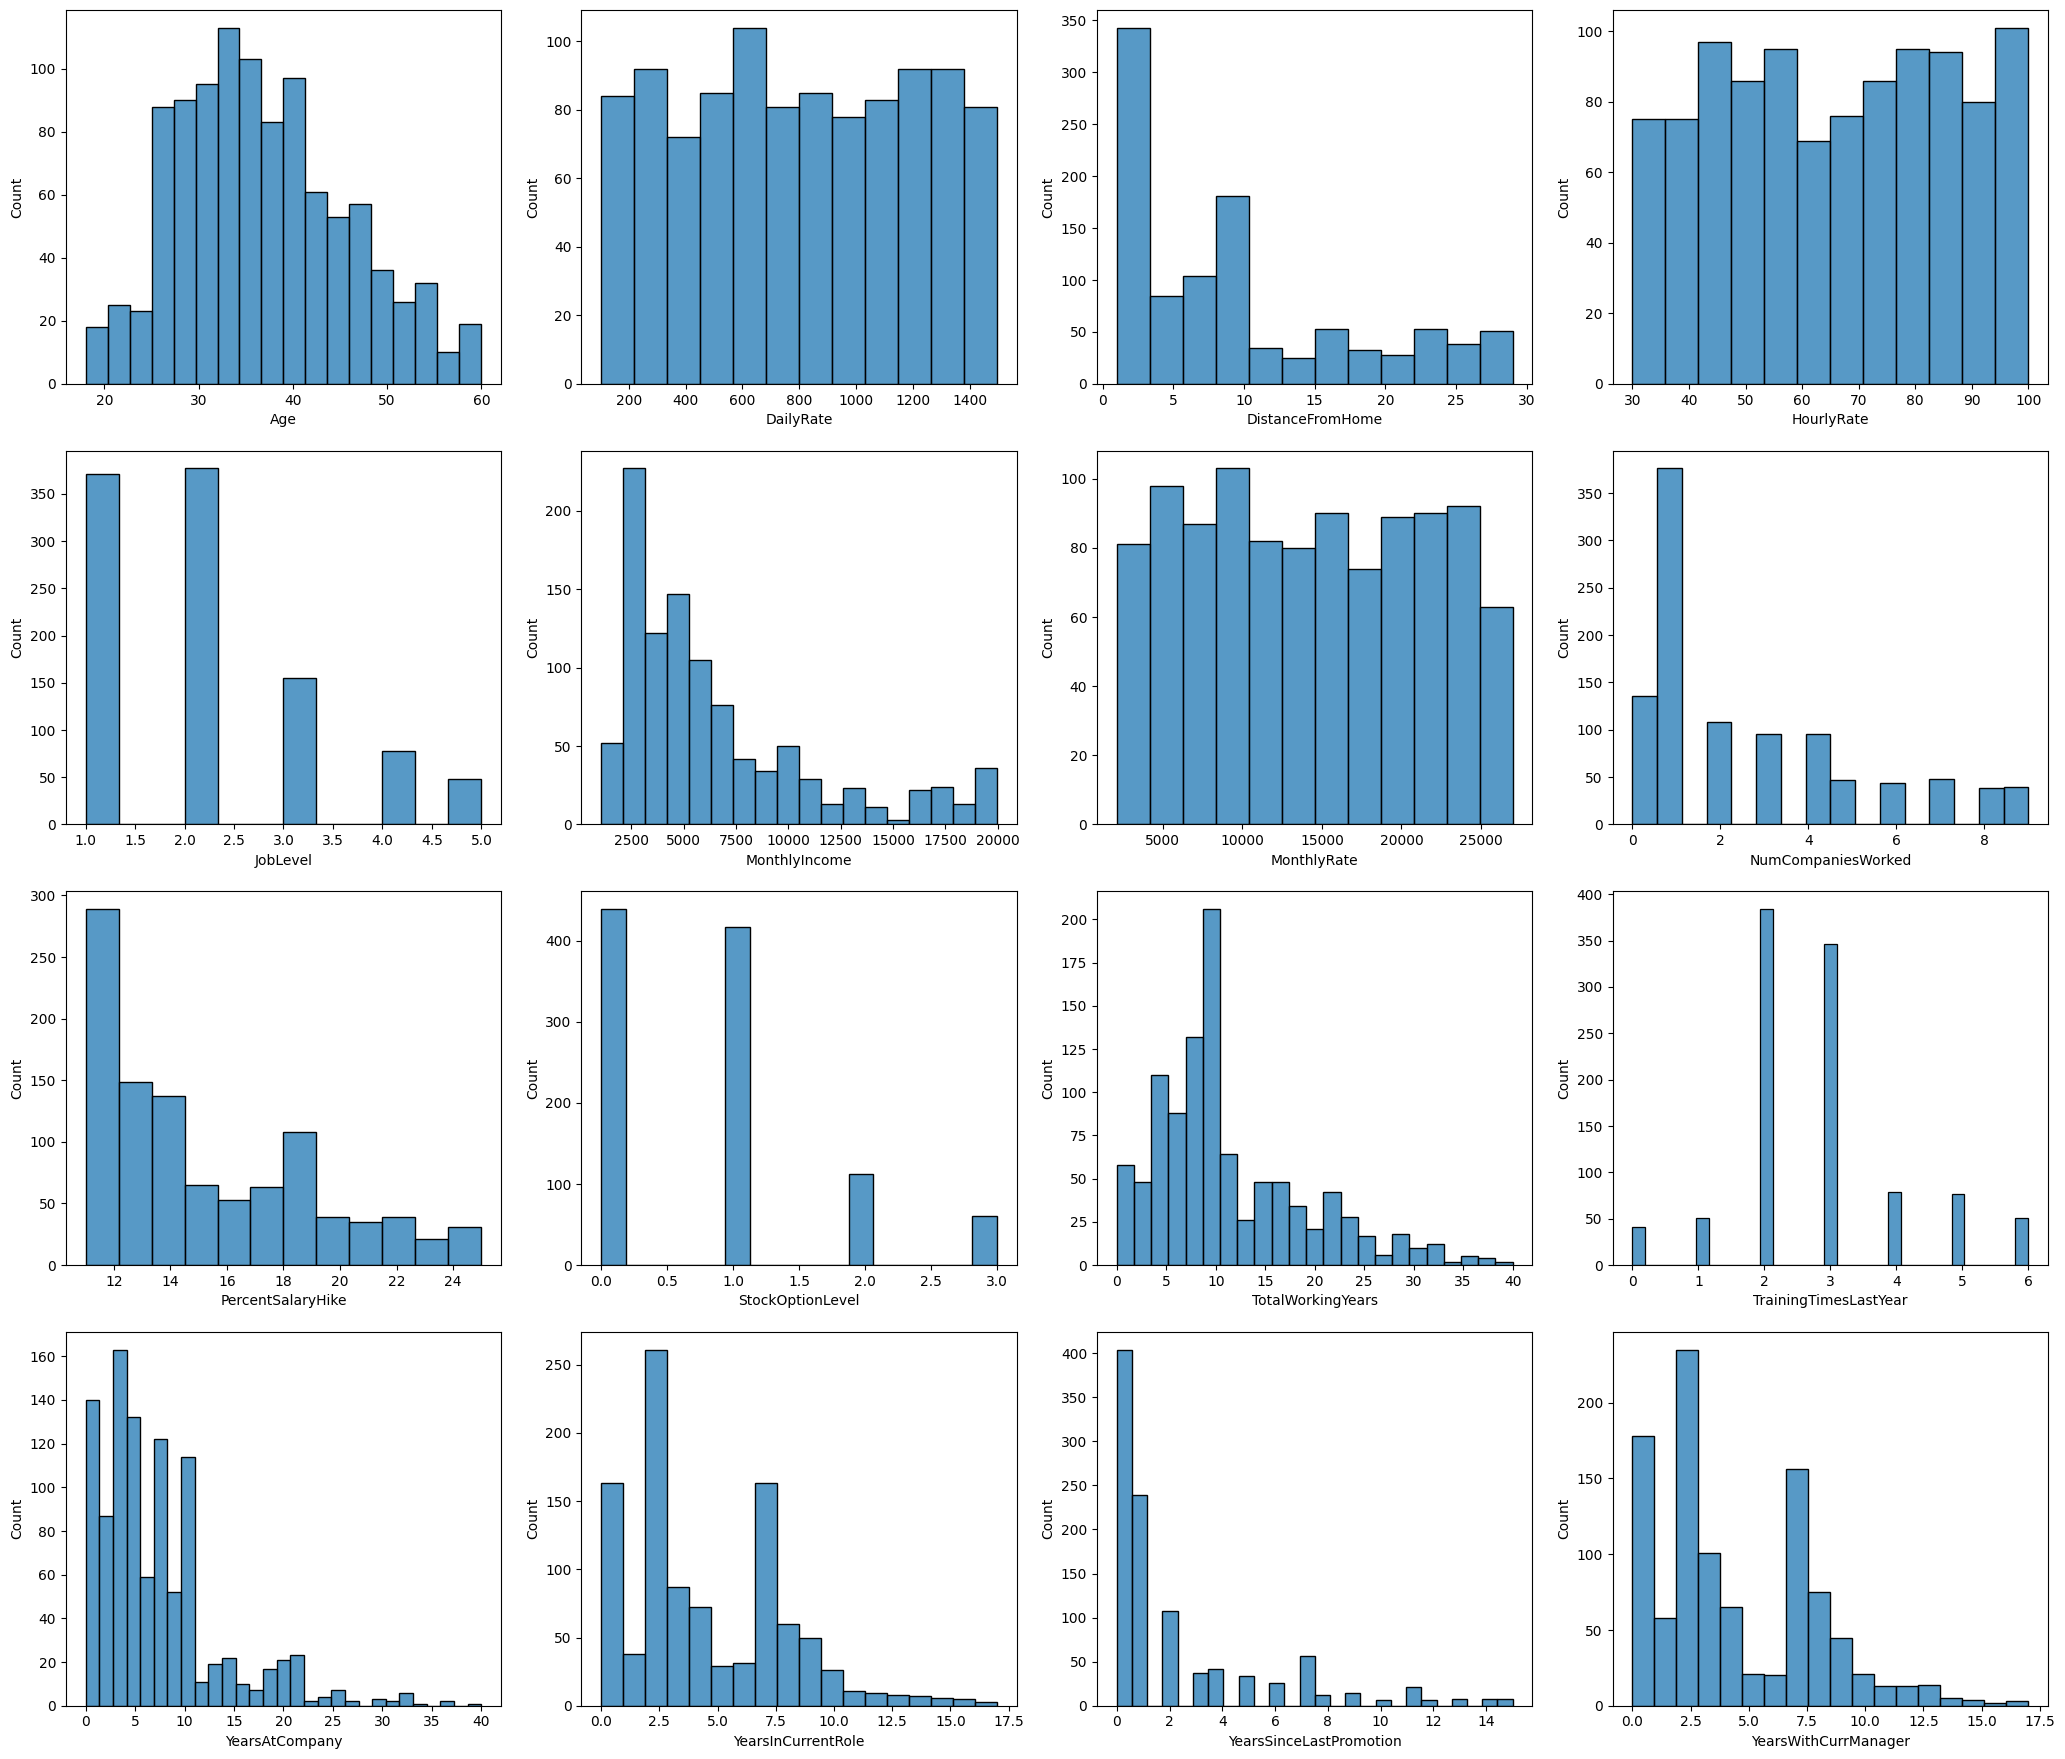

In [14]:
numericXtrain = Xtrain.select_dtypes(include='int64')

fig, axes = plt.subplots(4, 4, figsize=(21,18))

axes = axes.ravel()
fig.tight_layout(pad=2.7)
for col, ax in zip(numericXtrain.columns, axes):
    sns.histplot(numericXtrain, x=col, ax=ax)

**Aplicando la Transformación los conjuntos de entrenamiento, validación y prueba**

In [15]:
scaler = MinMaxScaler()

XtrainCols = Xtrain.select_dtypes(include='int64').columns
XvalCols = Xval.select_dtypes(include='int64').columns
XtestCols = Xtest.select_dtypes(include='int64').columns

scaler.fit(Xtrain[XtrainCols])

XtrainO = pd.DataFrame(scaler.transform(Xtrain[XtrainCols]), columns=XtrainCols)
XvalO = pd.DataFrame(scaler.transform(Xval[XvalCols]), columns=XvalCols)
XtestO = pd.DataFrame(scaler.transform(Xtest[XtestCols]), columns=XtestCols)


XtrainO.index = Xtrain.index
XvalO.index = Xval.index
XtestO.index = Xtest.index

XtrainT = pd.concat([XtrainO], axis=1)
XvalT = pd.concat([XvalO], axis=1)
XtestT = pd.concat([XtestO], axis=1)

**Aplica la transformación LabelEncoder() de sklearn a todas las variables binarias, evitando el filtrado de información.**

In [16]:
# binary_cols = ['OverTime', 'Gender']
binary_cols = ['Gender']

for col in binary_cols:
    encoder = LabelEncoder()
    encoder.fit(Xtrain[col])
    
    XtrainO = pd.DataFrame(encoder.transform(Xtrain[col]), columns=[col])
    XvalO = pd.DataFrame(encoder.transform(Xval[col]), columns=[col])
    XtestO = pd.DataFrame(encoder.transform(Xtest[col]), columns=[col])
        
    XtrainO.index = XtrainT.index
    XvalO.index = XvalT.index
    XtestO.index = XtestT.index
    
    XtrainT = pd.concat([XtrainT, XtrainO], axis=1)
    XvalT = pd.concat([XvalT, XvalO], axis=1)
    XtestT = pd.concat([XtestT, XtestO], axis=1)


encoder = LabelEncoder()
encoder.fit(Ytrain)

YtrainO = pd.DataFrame(encoder.transform(Ytrain), columns=['Attrition'])
YvalO = pd.DataFrame(encoder.transform(Yval), columns=['Attrition'])
YtestO = pd.DataFrame(encoder.transform(Ytest), columns=['Attrition'])

YtrainO.index = Ytrain.index
YvalO.index = Yval.index
YtestO.index = Ytest.index

YtrainT = pd.concat([YtrainO], axis=1)
YvalT = pd.concat([YvalO], axis=1)
YtestT = pd.concat([YtestO], axis=1)

Considerando la distribución de la variable `Attrition` nos encontramos con un problema de classes no balanceadas

**Realiza una inspección de las variables ordinales y determina qué transformaciones aplicarles**

In [17]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical = ['MaritalStatus', 'JobRole', 'EducationField', 'Department', 'BusinessTravel'] 

encoder.fit(Xtrain[categorical])

XtrainO = pd.DataFrame(encoder.transform(Xtrain[categorical]))
XvalO = pd.DataFrame(encoder.transform(Xval[categorical]))
XtestO = pd.DataFrame(encoder.transform(Xtest[categorical]))

XtrainO.columns = encoder.get_feature_names_out()
XvalO.columns = encoder.get_feature_names_out()
XtestO.columns = encoder.get_feature_names_out()

XtrainO.index = Xtrain.index
XvalO.index = Xval.index
XtestO.index = Xtest.index

XtrainT = pd.concat([XtrainT, XtrainO], axis=1)
XvalT = pd.concat([XvalT, XvalO], axis=1)
XtestT = pd.concat([XtestT, XtestO], axis=1)

**Obtener la matriz de correlación de los factores obtenidos hasta el momento. Debes incluir la variable “Attrition”**

<Axes: >

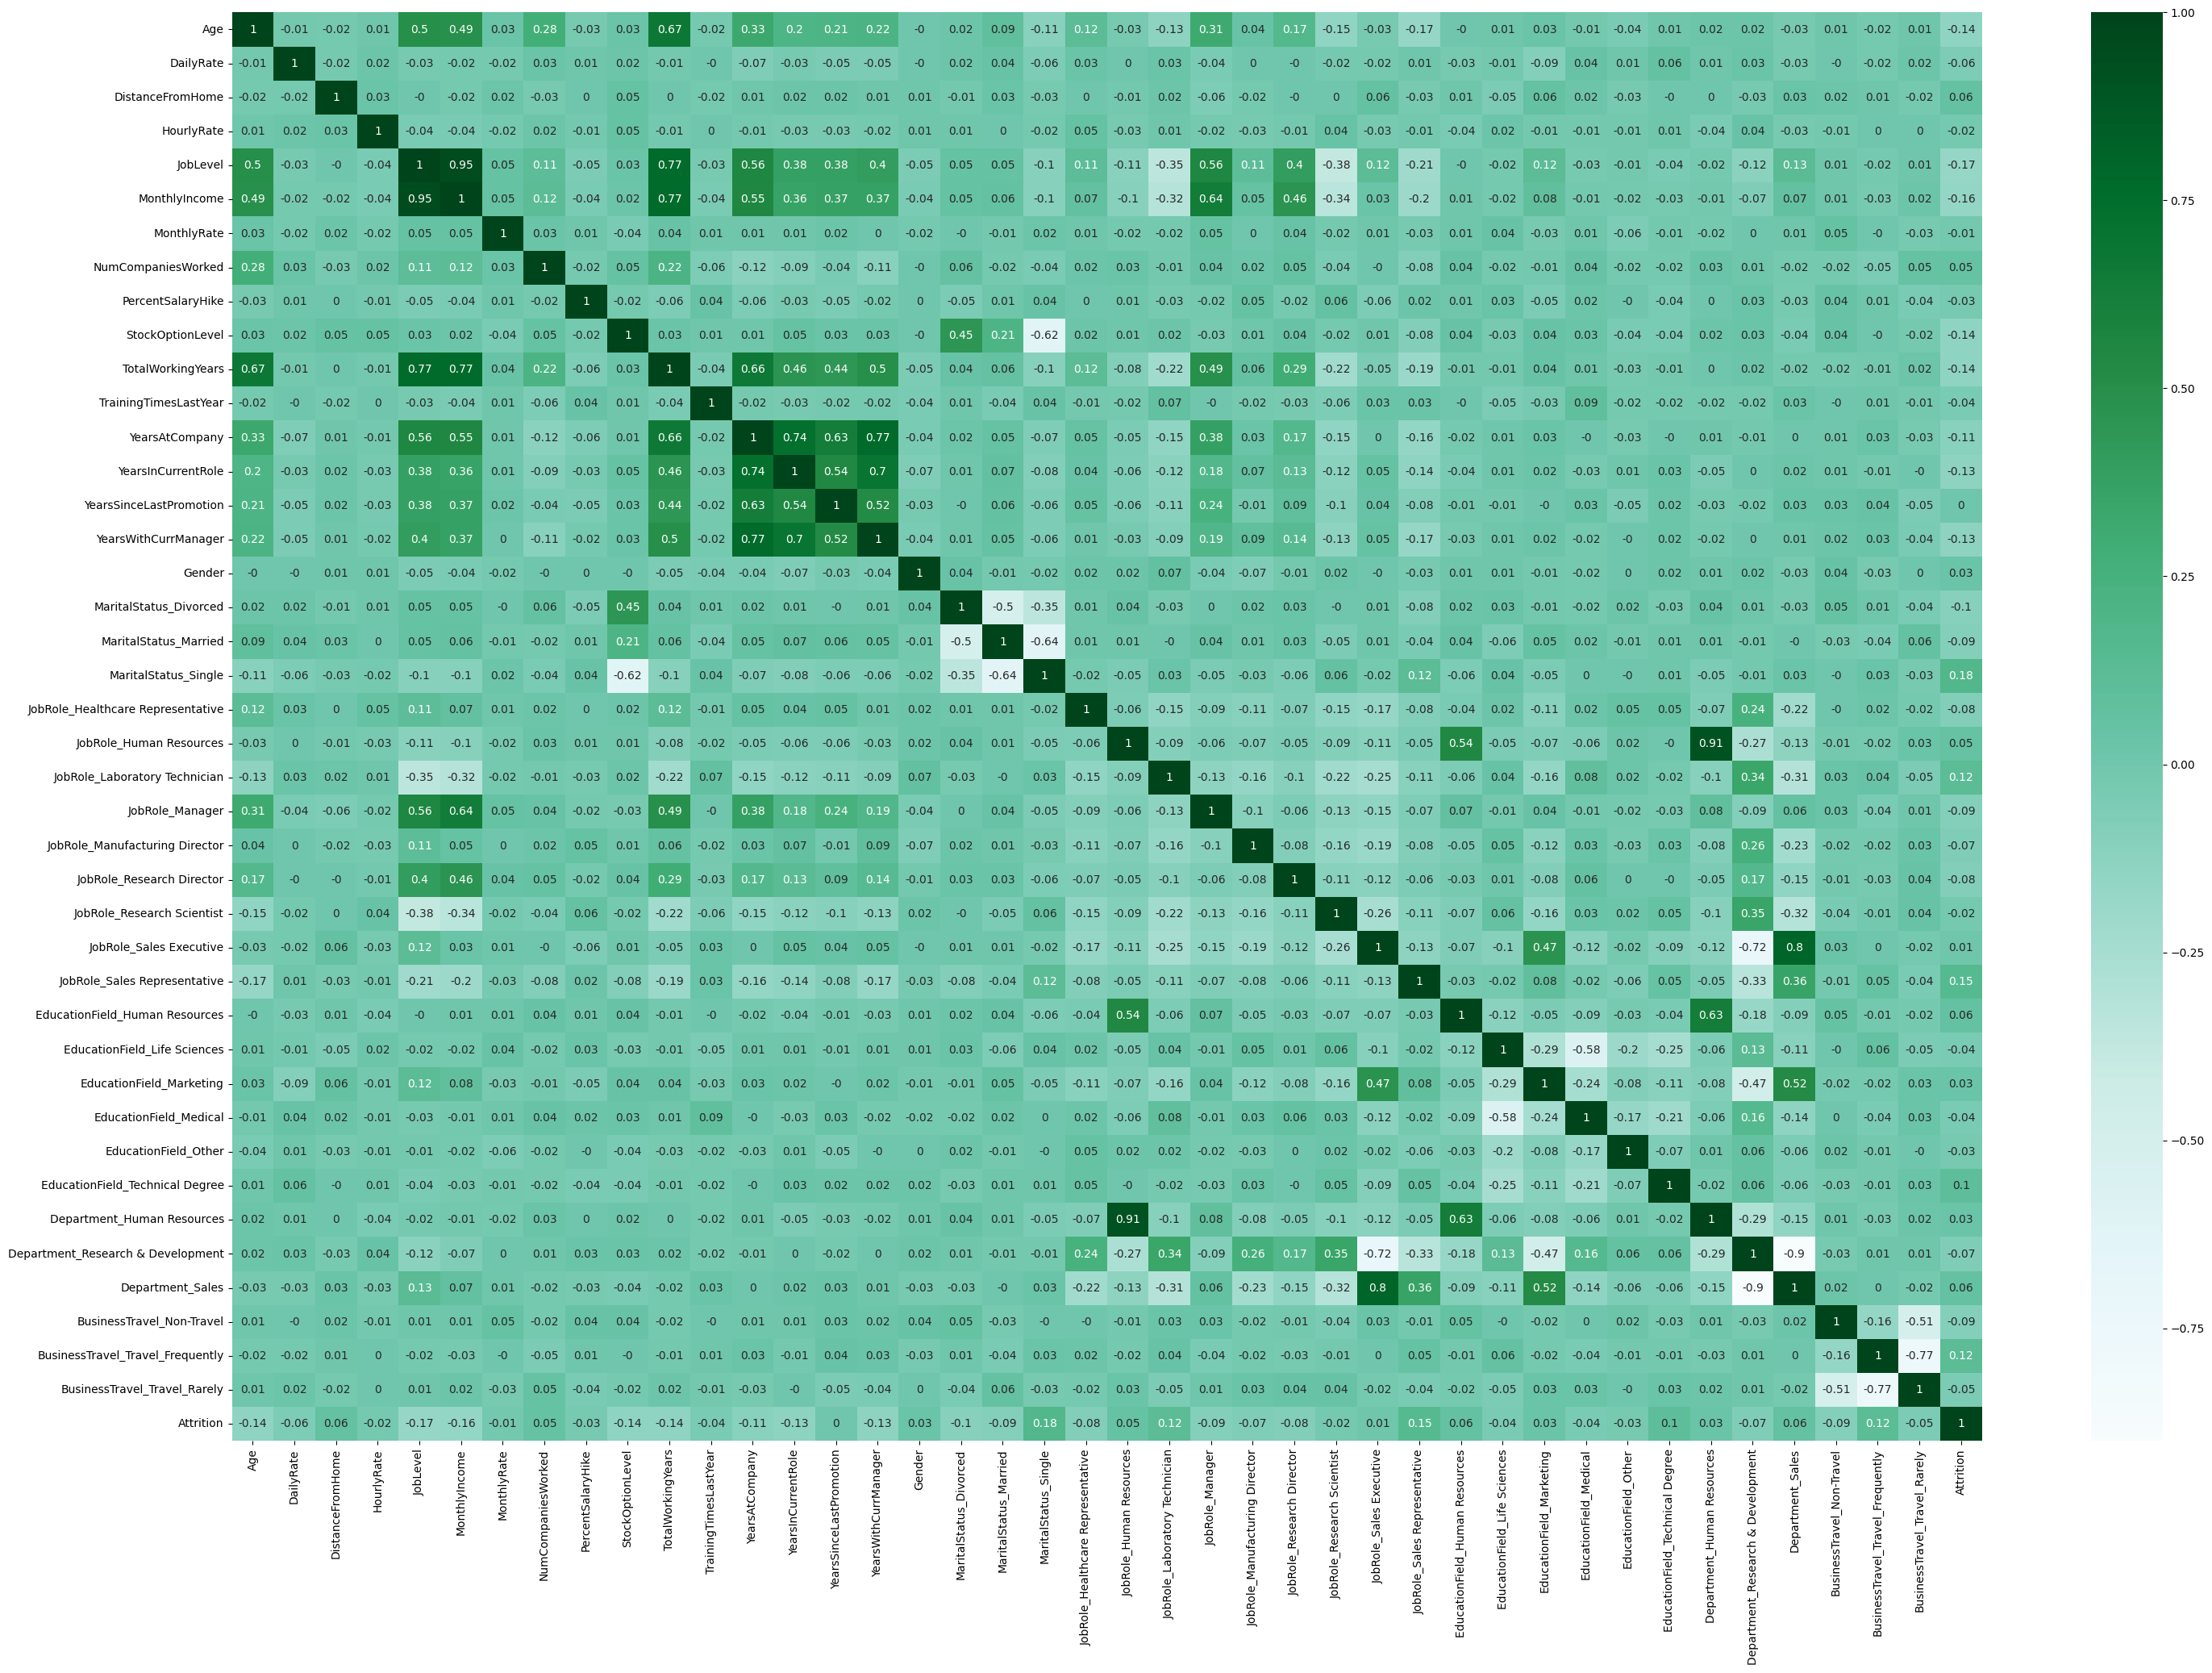

In [18]:
fig, axes = plt.subplots(1,1, figsize=(35,23))

corr_df = pd.concat([XtrainT, YtrainT], axis=1).corr()
sns.heatmap(round(corr_df, 2), cmap='BuGn', annot=True, ax=axes)

**Correlaciones Positivas Fuertes**

* MonthlyIncome
* JobLevel
* TotalWorkingYears
* YearsAtCompany
* YearsInCurrentRole
* YearsWithCurrManager
* JobRole_Human Resources
* Department_Human Resources
* EducationField_Human Resources
* JobRoles_Sales Executive
* Department_Sales
* EducationField_Marketing


**Correlaciones Negativas Fuertes**

 * MaritalStatus_Single
 * MaritalStatus_Married
 * Department_Research & Development
 * Department_Sales
 * BusinessTravel_Travel_Rarely
 * BusinessTravel_Travel_Frequently

**Aplica la transformación get_dummies() de Pandas a las variables nominales**

In [19]:
categorical = ['WorkLifeBalance', 'RelationshipSatisfaction', 'PerformanceRating', 'JobSatisfaction', 'JobInvolvement', 'EnvironmentSatisfaction', 'Education']

XtrainO = pd.DataFrame(pd.get_dummies(Xtrain[categorical], drop_first=True))
XvalO = pd.DataFrame(pd.get_dummies(Xval[categorical], drop_first=True))
XtestO = pd.DataFrame(pd.get_dummies(Xtest[categorical], drop_first=True))

XtrainT = pd.concat([XtrainT, XtrainO], axis=1)
XvalT = pd.concat([XvalT, XvalO], axis=1)
XtestT = pd.concat([XtestT, XtestO], axis=1)

## PARTE 2: Análisis exploratorio entre factores

Para este ejercicio usaremos una adaptación de la gráfica scatterplot, **swarmplot**, esta nos permitirá observar tendencias con valores categóricos.

<Axes: xlabel='Attrition', ylabel='Age'>

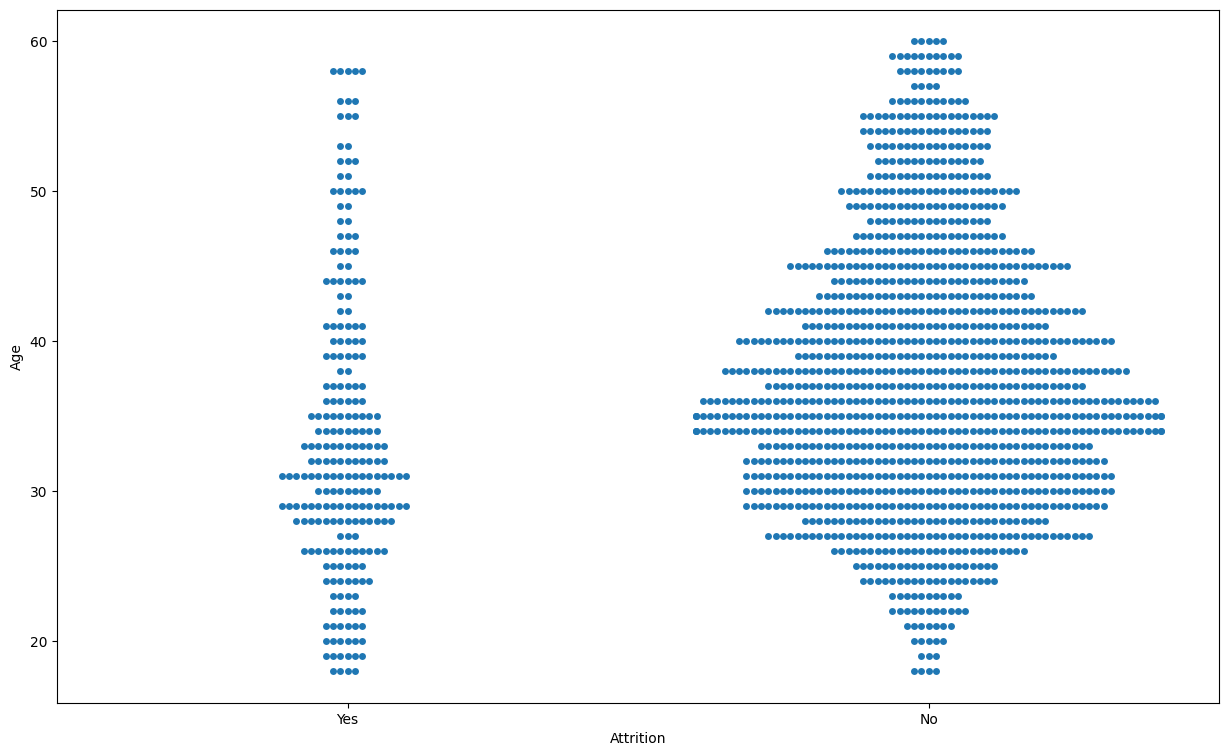

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(15,9))
sns.swarmplot(attrition_df, y='Age', x='Attrition', ax=axes)

<Axes: xlabel='Gender', ylabel='Age'>

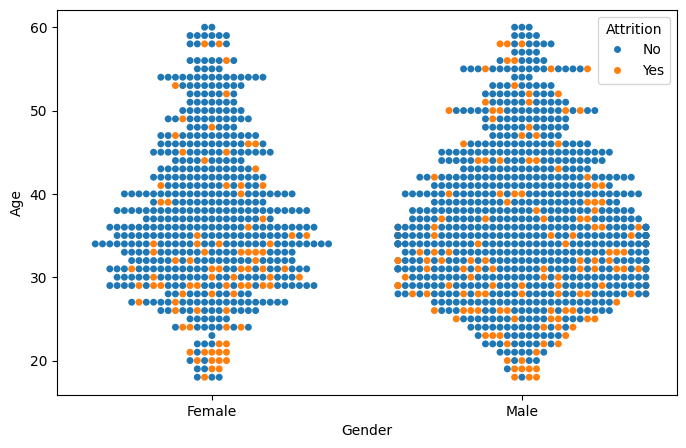

In [21]:
fig, axes = plt.subplots(1,1, figsize=(8,5))
sns.swarmplot(attrition_df, x='Gender', y='Age', hue='Attrition', hue_order=['No', 'Yes'])

<Axes: xlabel='Department', ylabel='JobRole'>

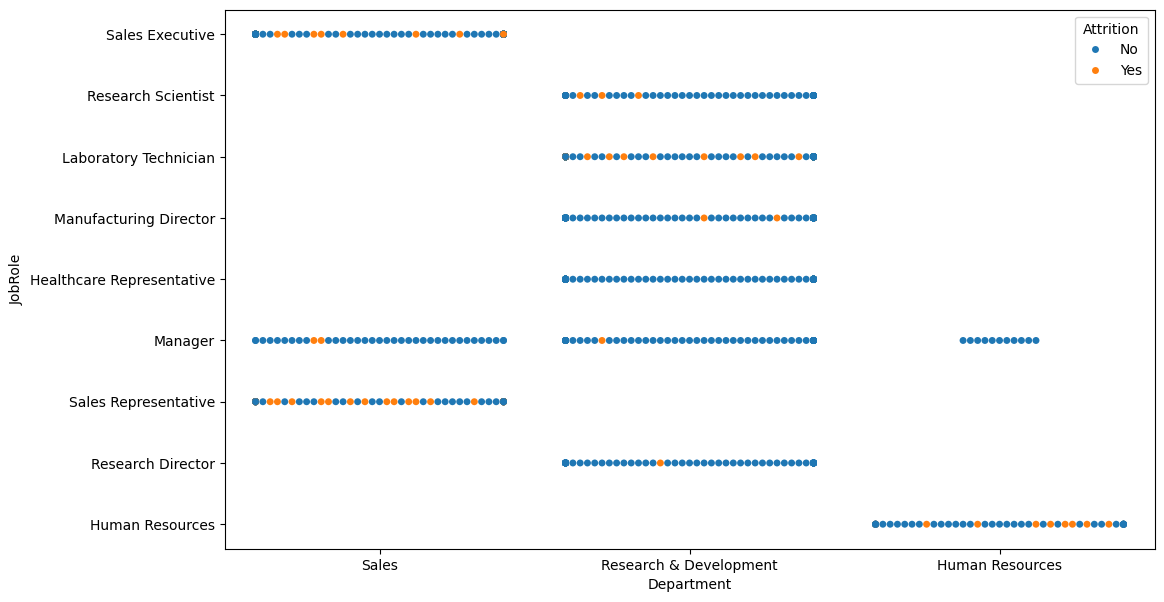

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(12,7))
sns.swarmplot(attrition_df, x='Department', y='JobRole', hue='Attrition', ax=axes, hue_order=['No', 'Yes'])

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Sales Executive'),
  Text(1, 0, 'Research Scientist'),
  Text(2, 0, 'Laboratory Technician'),
  Text(3, 0, 'Manufacturing Director'),
  Text(4, 0, 'Healthcare Representative'),
  Text(5, 0, 'Manager'),
  Text(6, 0, 'Sales Representative'),
  Text(7, 0, 'Research Director'),
  Text(8, 0, 'Human Resources')])

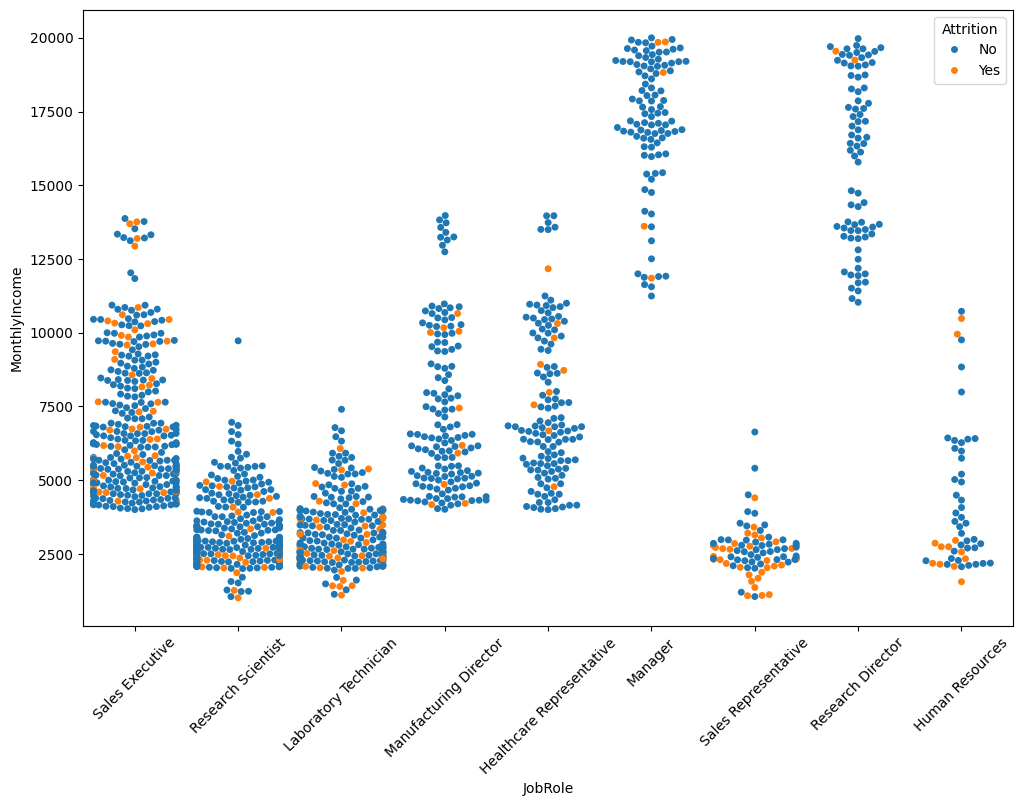

In [23]:
fig, axes = plt.subplots(1,1, figsize=(12,8))
sns.swarmplot(attrition_df, y='MonthlyIncome', x='JobRole', hue='Attrition', hue_order=['No', 'Yes'])
plt.xticks(rotation=45)

<Axes: xlabel='TotalWorkingYears', ylabel='YearsWithCurrManager'>

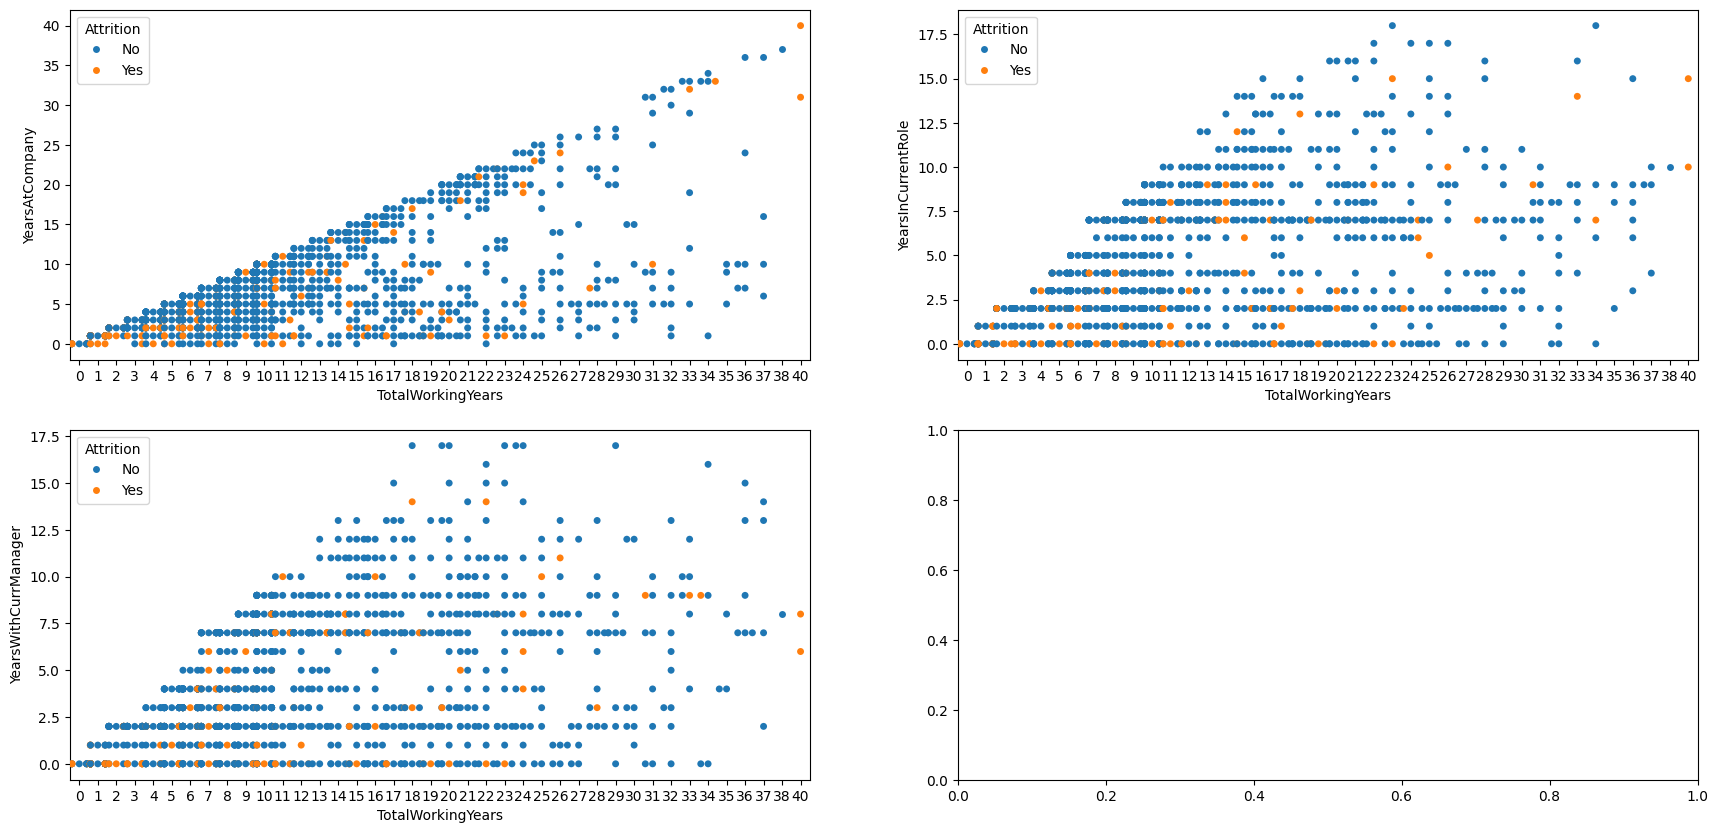

In [24]:
fig, axes = plt.subplots(2,2, figsize=(21,10))

axes = axes.ravel()

sns.swarmplot(attrition_df, x='TotalWorkingYears', y='YearsAtCompany', hue='Attrition', ax=axes[0], hue_order=['No', 'Yes'])
sns.swarmplot(attrition_df, x='TotalWorkingYears', y='YearsInCurrentRole', hue='Attrition', ax=axes[1], hue_order=['No', 'Yes'])
sns.swarmplot(attrition_df, x='TotalWorkingYears', y='YearsWithCurrManager', hue='Attrition', ax=axes[2], hue_order=['No', 'Yes'])

<Axes: xlabel='NumCompaniesWorked', ylabel='Age'>

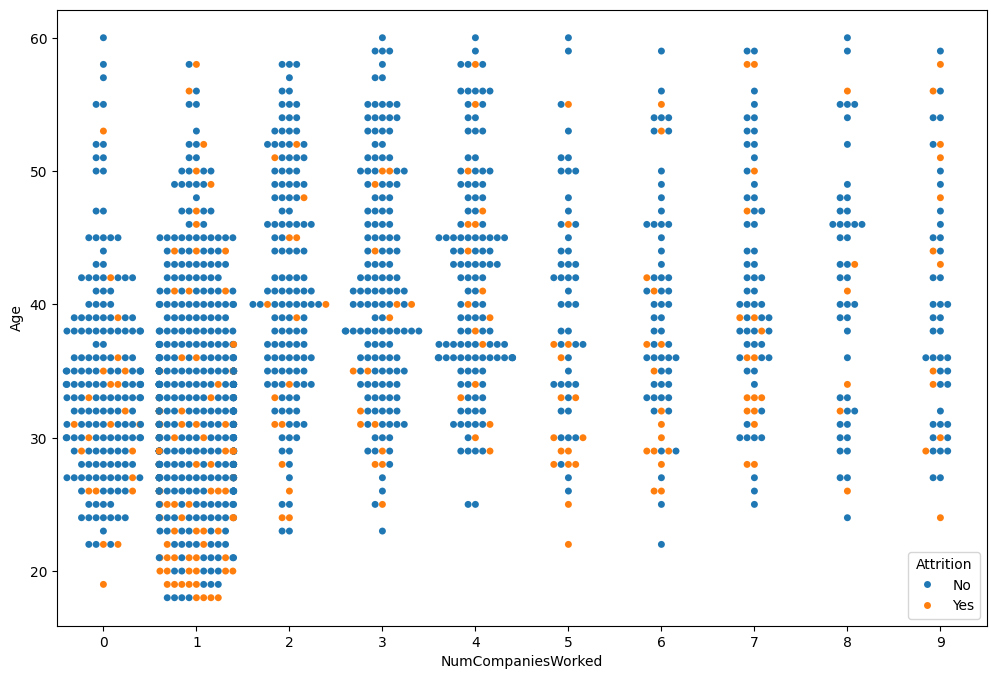

In [25]:
fig, axes = plt.subplots(1,1, figsize=(12,8))
sns.swarmplot(attrition_df, y='Age', x='NumCompaniesWorked', hue='Attrition', hue_order=['No', 'Yes'])

<Axes: xlabel='MaritalStatus', ylabel='Age'>

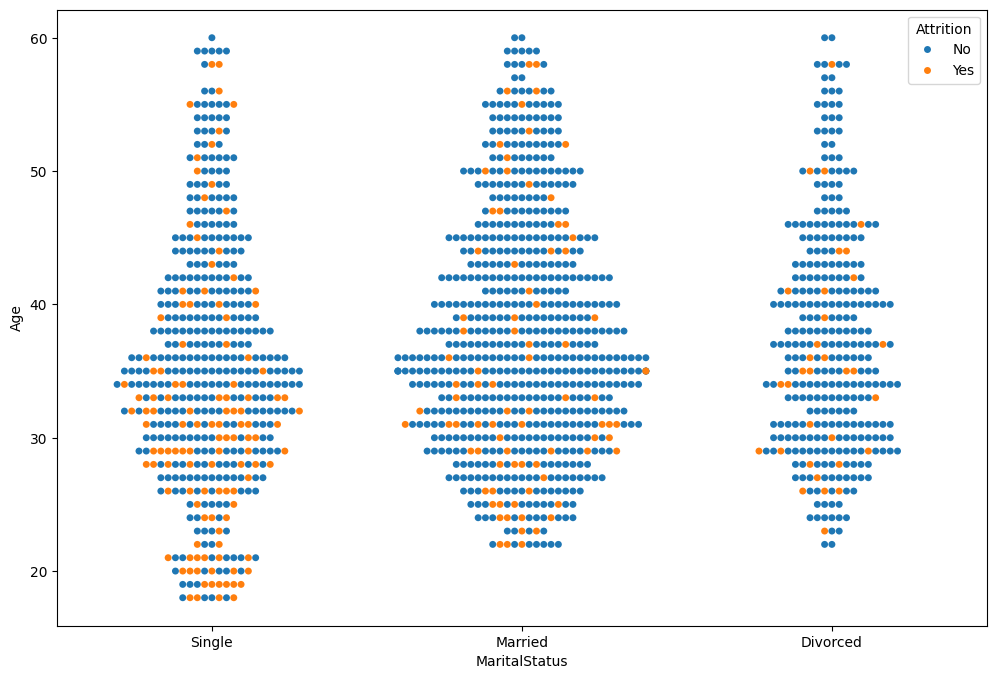

In [26]:
fig, axes = plt.subplots(1,1, figsize=(12,8))
sns.swarmplot(attrition_df, y='Age', x='MaritalStatus', hue='Attrition', hue_order=['No', 'Yes'])

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Sales Executive'),
  Text(1, 0, 'Research Scientist'),
  Text(2, 0, 'Laboratory Technician'),
  Text(3, 0, 'Manufacturing Director'),
  Text(4, 0, 'Healthcare Representative'),
  Text(5, 0, 'Manager'),
  Text(6, 0, 'Sales Representative'),
  Text(7, 0, 'Research Director'),
  Text(8, 0, 'Human Resources')])

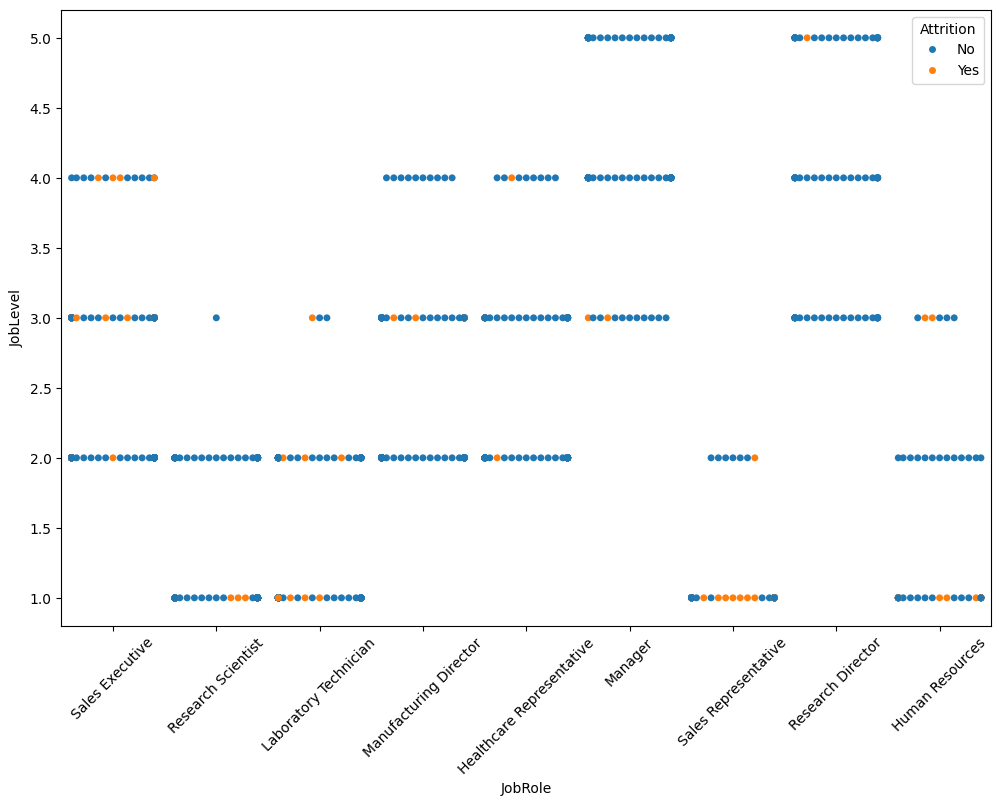

In [27]:
fig, axes = plt.subplots(1,1, figsize=(12,8))
sns.swarmplot(attrition_df, y='JobLevel', x='JobRole', hue='Attrition', hue_order=['No', 'Yes'])
plt.xticks(rotation=45)

<Axes: xlabel='JobLevel', ylabel='Age'>

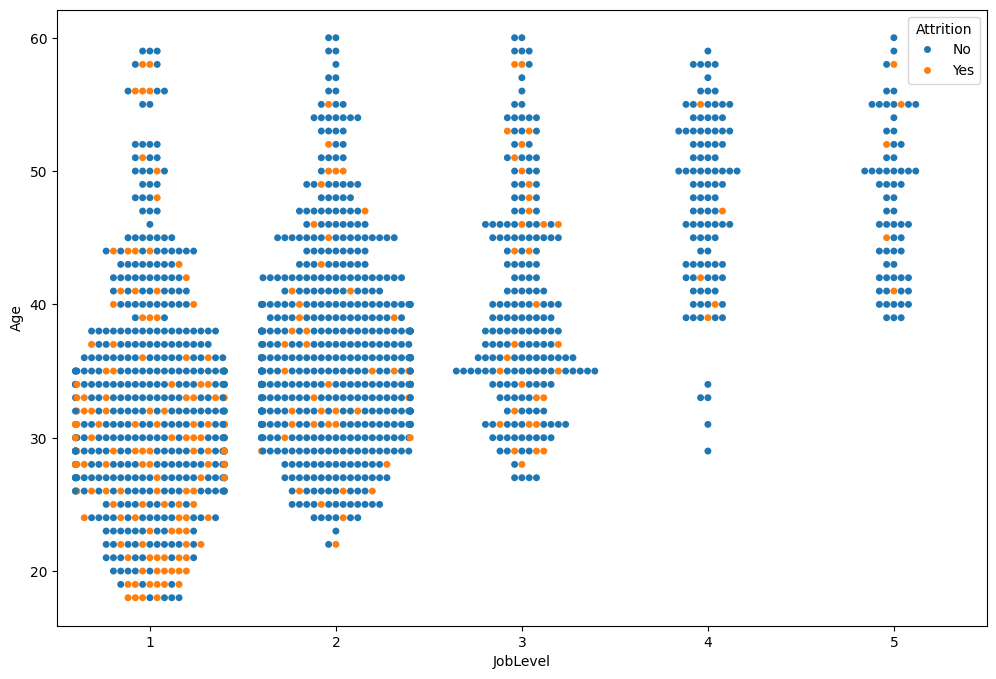

In [28]:
fig, axes = plt.subplots(1,1, figsize=(12,8))
sns.swarmplot(attrition_df, y='Age', x='JobLevel', hue='Attrition', hue_order=['No', 'Yes'])

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Life Sciences'),
  Text(1, 0, 'Other'),
  Text(2, 0, 'Medical'),
  Text(3, 0, 'Marketing'),
  Text(4, 0, 'Technical Degree'),
  Text(5, 0, 'Human Resources')])

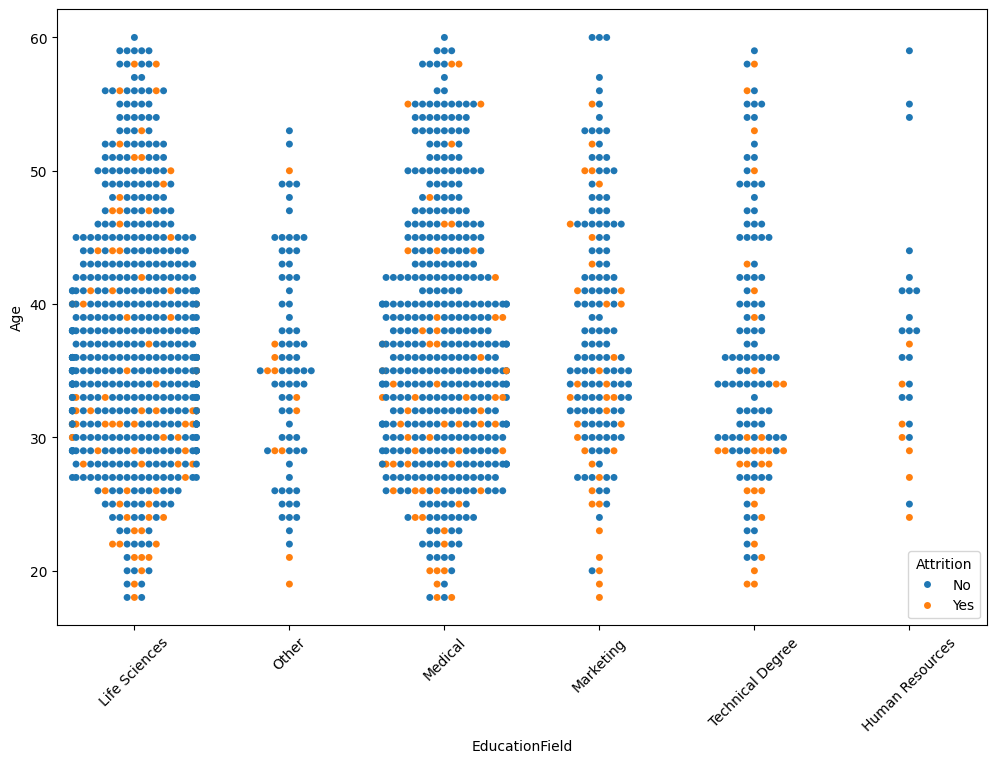

In [29]:
fig, axes = plt.subplots(1,1, figsize=(12,8))
sns.swarmplot(attrition_df, y='Age', x='EducationField', hue='Attrition', hue_order=['No', 'Yes'])
plt.xticks(rotation=45)

**Conclusiones**

  * La primera grafica verificamos si hay correlación entre la edad y attrition, como podemos observar no hay factores que nos hagan pensar que es correcta esta aceveración.
  * En la segunda gráfica mostramos edad contra género y podemos observar que es relativamente homogéneo, es decir, no hay una tendencia marcada hacia ningún género o edad.
  * Tercer gráfica mostramos la correlación entre el departamento y attrition, para comprobar esta relación gráficamos departamento contra puesto de trabajo y encontramos que ciertos roles tienen una ligera tendencia hacia attrition como **Sales Representative**, **Sales Executive**, **Human Resources**, y **Laboratory Technician**.
  * En la cuarta gráfica se muestra la relación entre ingreso mensual y puesto de trabajo y encontramos que entre los puestos con el salario más bajo se encuentran **Sales Executive**, **Human Resource**, y **Laboratory Technician** entre los resaltados del punto anterior. **Sales Representative** a pesar de no estar en los salarios bajos necesitamos encontrar otros datos para confirmar las hipótesis.
  * Quinta gráfica mostramos TotalWorkingYears contra (YearsAtCompany, YearsInCurrentRole, and YearsWithCurrManager) se puede observar que no hay una tendencia significativa entre los años de trabajo, los años trabajados en la compañia, los años en el puesto de trabajo actual y los años trabajados con el manager actual.
  * Sexta y Séptima gráfica, Age vs NumCompaniesWorked y Age vs MaritalStatus respectivamente no existe una tendencia marcada hacia algun sector de la población
  * Octava gráfica se intento correlacionar el área de estudios con la edad sin embargo no se encontro alguna tendencia significativa

## PARTE 3: Modelado

In [30]:
# Model Creation
logr = LogisticRegression()
logr

LogisticRegression()

In [31]:
# Model Trainning
logr.fit(XtrainT, YtrainT)

LogisticRegression()

In [32]:
# Create the Predictions
YPredTrainT = logr.predict(XtrainT)
YPredValT = logr.predict(XvalT)

In [33]:
# Calculate the Accuracy
train_acc = accuracy_score(YtrainT, YPredTrainT)
val_acc = accuracy_score(YvalT, YPredValT)

f'Trainning Accuracy {train_acc:.2f} and Validation Accuracy {val_acc:.2f}'

'Trainning Accuracy 0.86 and Validation Accuracy 0.85'

In [34]:
cfn_matrix = confusion_matrix(YvalT, YPredValT)
report = classification_report(YvalT, YPredValT)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       185
           1       0.62      0.23      0.33        35

    accuracy                           0.85       220
   macro avg       0.74      0.60      0.63       220
weighted avg       0.83      0.85      0.83       220



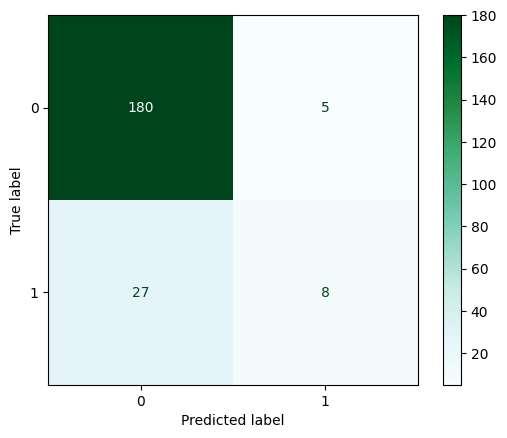

In [35]:
disp = ConfusionMatrixDisplay(cfn_matrix)
disp.plot(cmap='BuGn')

**Con base a estos resultados, ¿podemos decir que el modelo está subentrenado (underfitting)? ¿o sobreentrenado (overfitting)?**

El anterior modelo anterior esta **sobreentrenado** para la clase **negativa**, es decir, la clase que no es prioritaria para este problema

**¿Consideras que tenemos un problema desbalanceado?**

Si, puesto que hay muchos mas ejemplos para la clase negativa podemos decir que el modelo se esta sobreentrenando o aprendiendo mas acerca de la clase negativa

**Interpreta el valor numérico de la “precision” de la clase positiva.**

Precision se refiere al porcentaje de las predicciones que son correctas, es decir 67% de las predicciones son verdaderos positivos, personas que realmente renunciaron mientras que el 33% restante son personas que se evaluo que renunciarían cuando no es verdad o falso positivo.

**Interpreta el valor numérico del “recall” de la clase positiva.**

Recall se refiere al porcentaje de predicciones relevantes correctamente identificadas por el modelo, en otras palabras, solo 17% fueron realmente Verdaderos Positivos, personas que realmente renunciaron mientras que el restante 83% fueron predicciones negativas que resultaron positivas o personas que se evaluó que no renunciarían cuando si se fueron de la empresa.

**¿Cuál de las métricas, “precision” o “recall” consideras que es más importante disminuir su valor**

Desde mi punto de vista es mejor aumentar el recall. Porque así en las empresas en el área de reclutamiento y selección de personal se podría ser más exacto para reemplazar a las personas que realmente se esta evaluando que van a renunciar sin sobredimensionar o minimizar el presupuesto.

In [36]:
# Model Creation
knn = KNeighborsClassifier()
knn

KNeighborsClassifier()

In [37]:
# Model Trainning
knn.fit(XtrainT, YtrainT)

KNeighborsClassifier()

In [38]:
# Create the Predictions
YPredTrainT = knn.predict(XtrainT)
YPredValT = knn.predict(XvalT)

In [39]:
# Calculate the Accuracy
train_acc = accuracy_score(YtrainT, YPredTrainT)
val_acc = accuracy_score(YvalT, YPredValT)

f'Trainning Accuracy {train_acc:.2f} and Validation Accuracy {val_acc:.2f}'

'Trainning Accuracy 0.87 and Validation Accuracy 0.85'

In [40]:
cfn_matrix = confusion_matrix(YvalT, YPredValT)
report = classification_report(YvalT, YPredValT)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       185
           1       0.55      0.17      0.26        35

    accuracy                           0.85       220
   macro avg       0.70      0.57      0.59       220
weighted avg       0.81      0.85      0.81       220



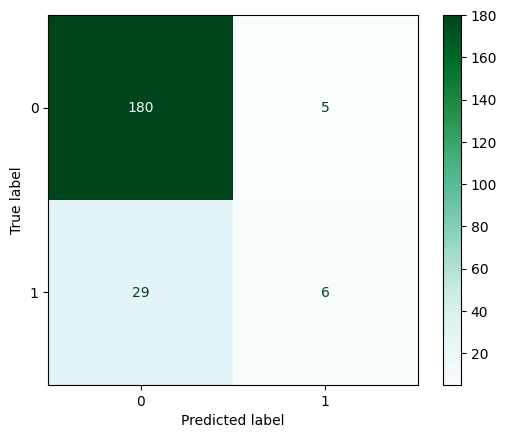

In [41]:
disp = ConfusionMatrixDisplay(cfn_matrix)
disp.plot(cmap='BuGn')

**Compara los resultados con los del modelo de Regresión Logística y escribe tus conclusiones**

La técnica KNN tiene un desempeño igual o peor que la regresión logística puesto que se esta sobreentrenando para la clase negativa.

## PARTE 4: Balanceo de Clases

**Utiliza el argumento “class_weight” de la función LogisticRegression() de sklearn y los valores de los hiperparámetros que consideres más adecuados para obtener un modelo no sobreentrenado.**

In [42]:
logr2 = SGDClassifier(class_weight='balanced', learning_rate='optimal')
logr2

SGDClassifier(class_weight='balanced')

In [43]:
logr2.fit(XtrainT, YtrainT)

SGDClassifier(class_weight='balanced')

In [44]:
YPredTrainT = logr2.predict(XtrainT)
YPredValT = logr2.predict(XvalT)

In [45]:
# Calculate the Accuracy
train_acc = accuracy_score(YtrainT, YPredTrainT)
val_acc = accuracy_score(YvalT, YPredValT)

f'Trainning Accuracy {train_acc:.2f} and Validation Accuracy {val_acc:.2f}'

'Trainning Accuracy 0.81 and Validation Accuracy 0.80'

In [46]:
cfn_matrix = confusion_matrix(YvalT, YPredValT)
report = classification_report(YvalT, YPredValT)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       185
           1       0.40      0.54      0.46        35

    accuracy                           0.80       220
   macro avg       0.65      0.69      0.67       220
weighted avg       0.83      0.80      0.81       220



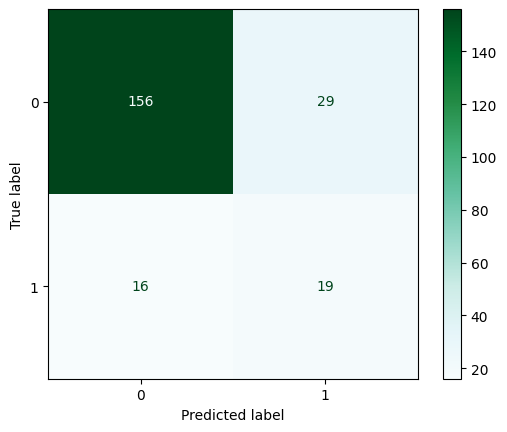

In [47]:
disp = ConfusionMatrixDisplay(cfn_matrix)
disp.plot(cmap='BuGn')

**Compara los resultados con los modelos anteriores**

El recall se incremento considerablemente en la clase de interés y la precisión del conjunto de entrenamiento y el conjunto de validación es considerablemente menor comparado con el modelo anterior por lo tanto se puede decir que el modelo esta sub-entrenado.

**Utiliza el método SMOTE de la librería “Imbalanced-learn” y los valores de los hiperparámetros que consideres más adecuados para obtener el mejor modelo posible**

In [48]:
def train(XtrainT, YtrainT, XvalT, YvalT, imb, model):
    X_resampled, y_resampled = imb.fit_resample(XtrainT, YtrainT)
    model.fit(X_resampled, y_resampled)
    YPredTrainT = model.predict(X_resampled)
    YPredValT = model.predict(XvalT)
    
    # Calculate the Accuracy
    train_acc = accuracy_score(y_resampled, YPredTrainT)
    val_acc = accuracy_score(YvalT, YPredValT)

    print(f'Trainning Accuracy {train_acc:.2f} and Validation Accuracy {val_acc:.2f}', end="\n\n\n")
    
    cfn_matrix = confusion_matrix(YvalT, YPredValT)
    report = classification_report(YvalT, YPredValT)
    print(report)
    
    disp = ConfusionMatrixDisplay(cfn_matrix)
    disp.plot(cmap='BuGn')
    return model

#### Modelo SMOTE

Trainning Accuracy 0.81 and Validation Accuracy 0.73


              precision    recall  f1-score   support

           0       0.90      0.77      0.83       185
           1       0.31      0.54      0.39        35

    accuracy                           0.73       220
   macro avg       0.60      0.66      0.61       220
weighted avg       0.80      0.73      0.76       220



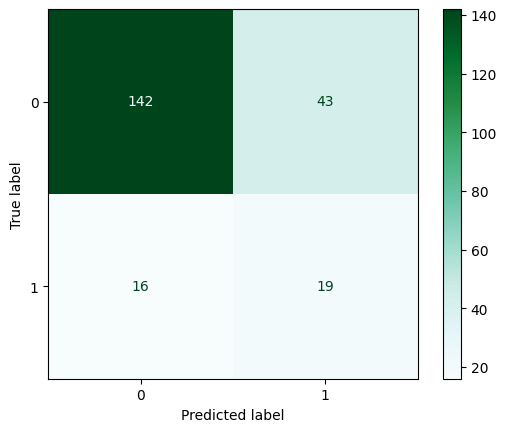

In [49]:
logr_smote = train(XtrainT, YtrainT, XvalT, YvalT, SMOTE(n_jobs=-1), SGDClassifier(learning_rate='optimal'))

#### Modelo SMOTEENN

Trainning Accuracy 0.86 and Validation Accuracy 0.70


              precision    recall  f1-score   support

           0       0.90      0.72      0.80       185
           1       0.28      0.57      0.37        35

    accuracy                           0.70       220
   macro avg       0.59      0.65      0.59       220
weighted avg       0.80      0.70      0.73       220



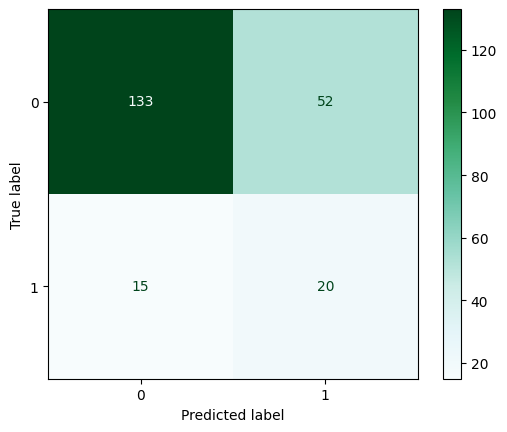

In [50]:
logr_smoteen = train(XtrainT, YtrainT, XvalT, YvalT, SMOTEENN(n_jobs=-1), SGDClassifier(learning_rate='optimal'))

#### Modelo SMOTETomek

Trainning Accuracy 0.79 and Validation Accuracy 0.72


              precision    recall  f1-score   support

           0       0.87      0.78      0.82       185
           1       0.25      0.37      0.30        35

    accuracy                           0.72       220
   macro avg       0.56      0.58      0.56       220
weighted avg       0.77      0.72      0.74       220



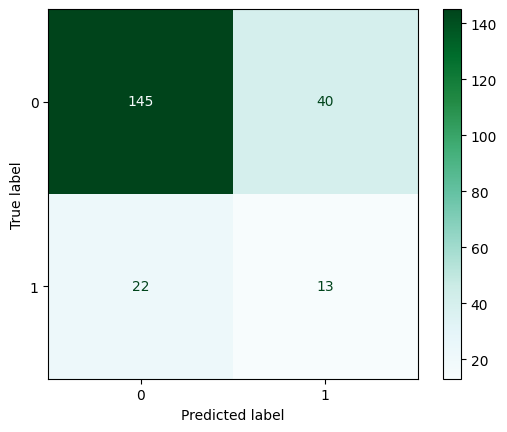

In [51]:
logr_smotetomek = train(XtrainT, YtrainT, XvalT, YvalT, SMOTETomek(n_jobs=-1), SGDClassifier(learning_rate='optimal'))

**Reporta los resultados del mejor modelo que hayas obtenido. Compáralo con los anteriores e incluye tus conclusiones.**

El modelo SMOTE no esta sobre-ajustado y sub-ajustado puesto que su accuracy para los conjuntos de datos estan separados por una mínima diferencia. El recall y precisión de la clase de interés es similar en ambos casos. El reporte de la matriz de confusión es equilibrado.

El modelo SMOTEENN esta sobre-entrenado puesto que el accuracy en el conjunto de validación, el modelo tiene menor desempeño que en el conjunto de prueba. El recall de la clase de interés es la sobrepasa la media y esta casi ajustado con el recall de la clase negativa acosta de la precisión de la clase positiva la cual es mucho menor.

El modelo SMOTETomek esta sub-ajustado puesto que el desempeño del accuracy en los conjuntos de validación y entrenamiento son bajos en comparación con otros modelos. El recall para la clase de interés es cerca de la media y la matriz de confusión para los FN obtuvo el desempeño intermedio de los tres modelos puestos a prueba.

## PARTE 5: La importancia de los factores

**Con base al mejor modelo de regresión logística obtenido hasta ahora, utiliza la magnitud de los coeficientes como métrica para identificar aquellos factores que se consideran los más importantes al problema de rotación de personal.**

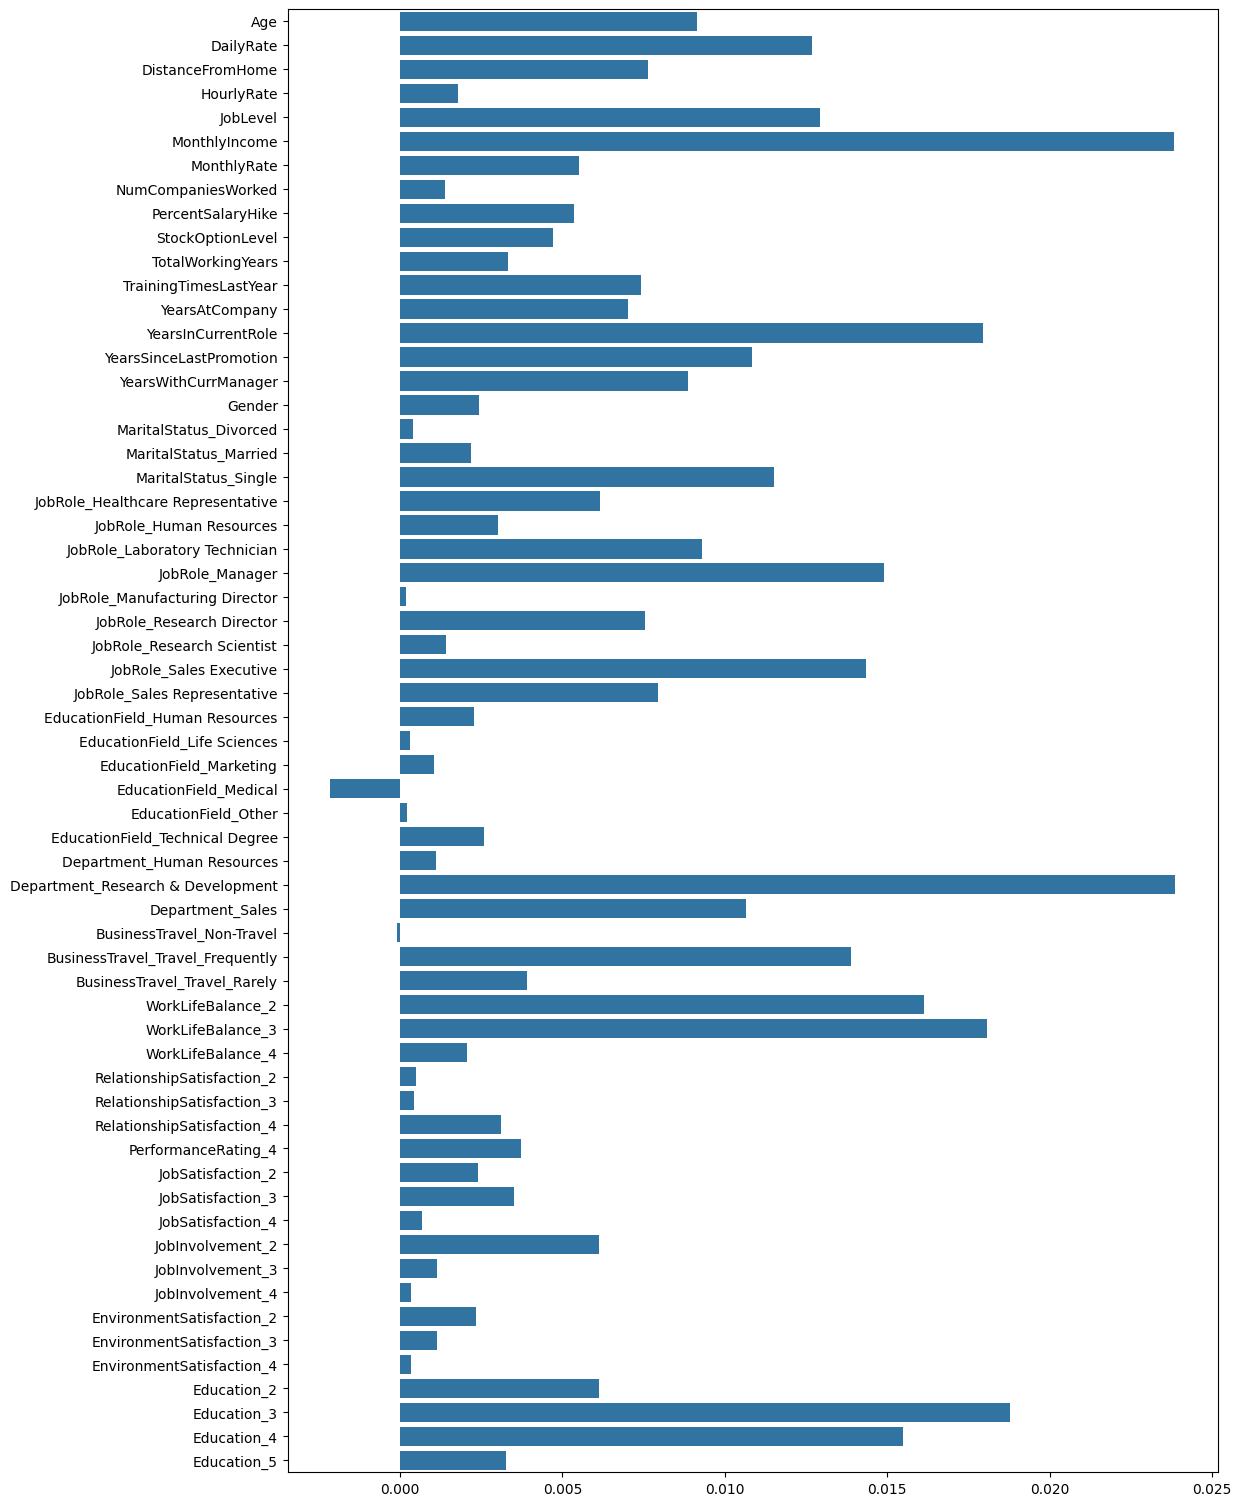

In [52]:
results = permutation_importance(logr_smoteen, XtrainT, YtrainT, scoring='f1_weighted')

importances = results.importances_mean

fig, axes = plt.subplots(1,1, figsize=(12, 19))
g = sns.barplot(importances, orient='y', ax=axes)

g.set_yticks(range(0,61), labels=XtrainT.columns)

**¿Cuáles factores consideras que son los que influyen mayormente a que un empleado abandone su trabajo (attrition)?**

Estado Civil en este caso soltero, La Frecuencia de Viajes de Trabajo, Nivel Educativo en este caso 'Bachelor', que tanta intervención tiene en su trabajo en este caso 'Medium' y la relación de calidad entre trabajo y vida social.

**¿Cuáles factores consideras que son los que influyen mayormente a que un empleado no abandone su trabajo (not attrition)?**

La intervención que tiene en su trabajo 'High', La cantidad de entrenamientos el último año, la distancia de su casa hasta el lugar del trabajo el balance entre vida personal y trabajo en este caso 'Better'.

**¿Cuál método te da los mejores factores que tienen mayor impacto en el problema de rotación de personal?**

El modelo entrenado con regresión logistica y SMOTEENN 

**Utiliza la clase SelectFromModel de sklearn para reducir la cantidad de factores del problema y volver a entrenar el modelo con los datos de entrenamiento y validación**

In [53]:
feature_selector = SelectFromModel(logr_smoteen, prefit=True, threshold=1.7)

feature_selector.fit(XtrainT, YtrainT)

factor_select = feature_selector.get_support()

In [54]:
XtrainTFS = pd.DataFrame(XtrainT)[pd.DataFrame(XtrainT).columns[factor_select]]
XvalTFS = pd.DataFrame(XvalT)[pd.DataFrame(XvalT).columns[factor_select]]
XtestTFS = pd.DataFrame(XtestT)[pd.DataFrame(XtestT).columns[factor_select]]

XtrainTFS.columns.T, XtrainTFS.shape

(Index(['DailyRate', 'JobLevel', 'MonthlyIncome', 'YearsAtCompany',
        'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'JobRole_Human Resources', 'JobRole_Laboratory Technician',
        'JobRole_Manager', 'JobRole_Research Director',
        'JobRole_Sales Representative', 'EducationField_Human Resources',
        'Department_Research & Development', 'BusinessTravel_Travel_Frequently',
        'WorkLifeBalance_3', 'WorkLifeBalance_4', 'Education_2', 'Education_3',
        'Education_5'],
       dtype='object'),
 (1029, 20))

**¿A cuántos factores pudiste reducir el problema?**

El problema con 61 Factores, con la técnica permutation importance se redujo a 21 factores.

Trainning Accuracy 0.67 and Validation Accuracy 0.70


              precision    recall  f1-score   support

           0       0.88      0.74      0.81       185
           1       0.26      0.49      0.34        35

    accuracy                           0.70       220
   macro avg       0.57      0.61      0.57       220
weighted avg       0.78      0.70      0.73       220



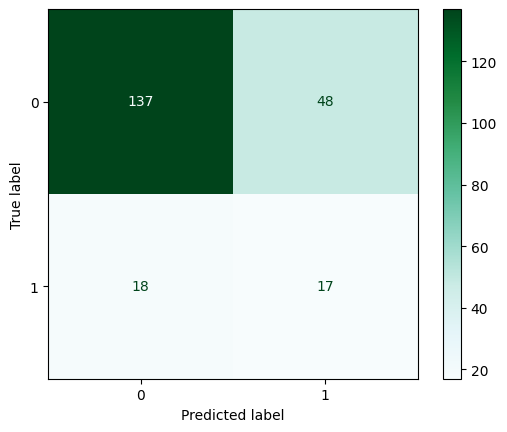

In [55]:
logr_fs = train(XtrainTFS, YtrainT, XvalTFS, YvalT, SMOTEENN(n_jobs=-1), SGDClassifier(learning_rate='optimal'))

## PARTE 6: Modelo final y conclusiones

**Forma un nuevo conjunto de Entrenamiento con los mejores conjuntos de entrenamiento y validación**

In [56]:
X_train = pd.concat([XtrainTFS, XvalTFS])
Y_train = pd.concat([YtrainT, YvalT])

X_train.shape, Y_train.shape

((1249, 20), (1249, 1))

**Selecciona el mejor modelo de aprendizaje automático que hayas obtenido hasta ahora**

Trainning Accuracy 0.78 and Validation Accuracy 0.53


              precision    recall  f1-score   support

           0       0.92      0.49      0.64       185
           1       0.23      0.78      0.35        36

    accuracy                           0.53       221
   macro avg       0.57      0.63      0.49       221
weighted avg       0.81      0.53      0.59       221



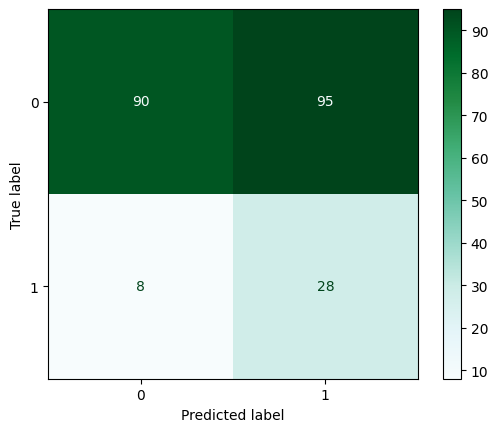

In [57]:
logr_smoteen3 = train(X_train, Y_train, XtestTFS, YtestT, SMOTEENN(n_jobs=-1), SGDClassifier(learning_rate='optimal'))

**interpreta y explica con base al problema de rotación de personal, los resultados obtenidos para las métricas “precision”, “recall” y “f1-score”.**

 * precision indica la relación entre las personas que realmente van a dejar su trabajo entre las personas que dejan el trabajo y los que se predijo que dejarían el trabajo pero **no** lo hicieron.
 * recall indica la relación entre las personas que realmente van a dejar su trabajo entre las personas que dejan el trabajo y los que se predijo que **no** dejarían trabajo pero lo hicieron.
 * f1-score indica la media o promedio entre precision y recall, es decir que tan balanceadas están las predicciones de ambas clases.

# Bibliografía

[1] CoachHub. (2023, July 4). 3 Problems with Employee Attrition. . . And What We Can Do About It. CoachHub. https://www.coachhub.com/blog/employee-attrition/

[2] IBM HR Analytics Employee Attrition & Performance. (2017, March 31). Kaggle. https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/data